<center># ==================== IMPORT LIBRARY ====================
</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

<center># ==================== 1. LOAD VÀ PHÂN TÍCH DỮ LIỆU ====================
</center>

=== BƯỚC 1: PHÂN TÍCH DỮ LIỆU ===

Tổng số mẫu: 349
Số lượng bệnh khác nhau: 116

Phân phối bệnh:
Disease
Asthma               23
Stroke               16
Osteoporosis         14
Diabetes             10
Hypertension         10
                     ..
Schizophrenia         1
Gout                  1
Testicular Cancer     1
Tonsillitis           1
Williams Syndrome     1
Name: count, Length: 116, dtype: int64


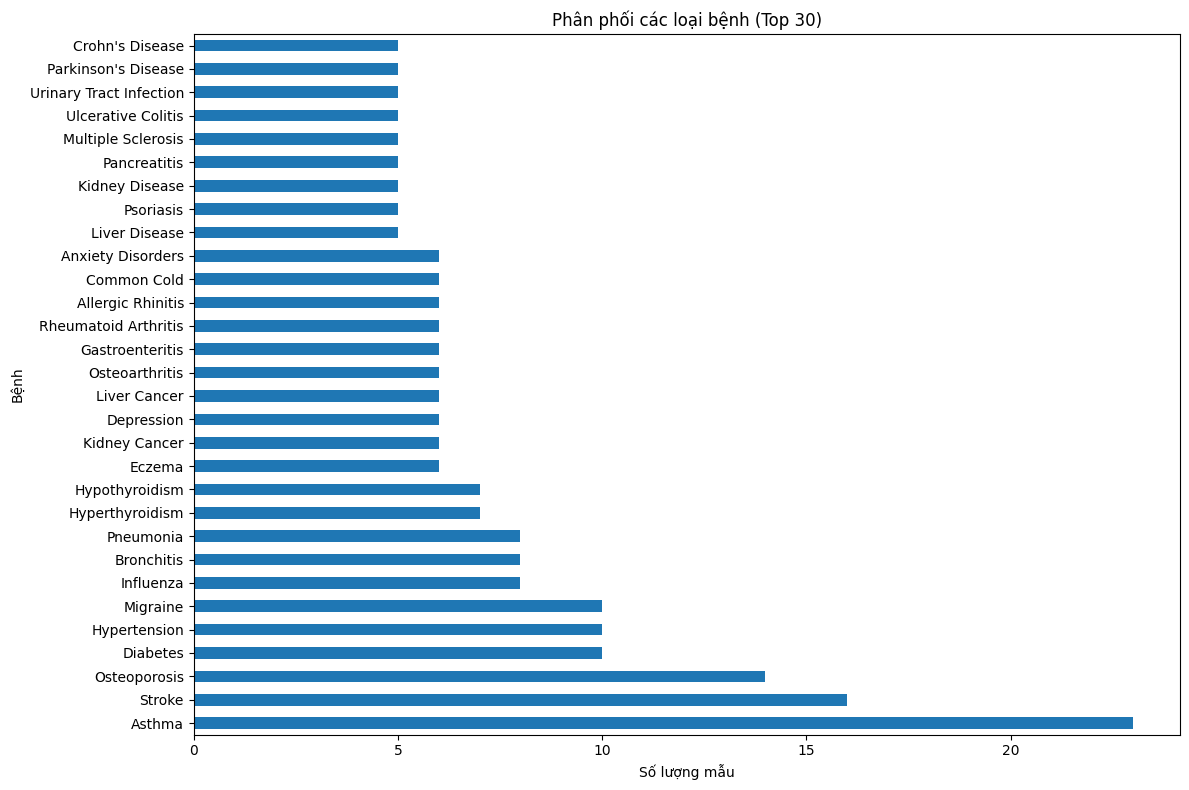

In [2]:

print("=== BƯỚC 1: PHÂN TÍCH DỮ LIỆU ===")
df = pd.read_csv(r"C:\Users\taing\Downloads\SmartHealth\AI_Predict\Disease_symptom_and_patient_profile_dataset.csv")
disease_names_v = LabelEncoder()
disease_names_v.fit(df['Disease'])

# Phân tích phân phối bệnh
disease_counts = df['Disease'].value_counts()
print(f"\nTổng số mẫu: {len(df)}")
print(f"Số lượng bệnh khác nhau: {len(disease_counts)}")
print(f"\nPhân phối bệnh:\n{disease_counts}")

# Visualize phân phối
plt.figure(figsize=(12, 8))
disease_counts[:30].plot(kind='barh')  # Hiển thị top 30 bệnh phổ biến
plt.title('Phân phối các loại bệnh (Top 30)')
plt.xlabel('Số lượng mẫu')
plt.ylabel('Bệnh')
plt.tight_layout()
plt.show() 


<center># ==================== 2. TIỀN XỬ LÝ DỮ LIỆU NÂNG CAO ====================
</center>

In [3]:
print("\n=== BƯỚC 2: TIỀN XỬ LÝ DỮ LIỆU ===")

# Nhóm các bệnh hiếm (ít hơn 5 mẫu) thành nhóm 'Other'
MIN_SAMPLES = 11  
common_diseases = disease_counts[disease_counts >= MIN_SAMPLES].index
df['Disease_Grouped'] = df['Disease'].apply(lambda x: x if x in common_diseases else 'Other_Rare_Diseases')

# Chọn các features quan trọng
features = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 
            'Age', 'Gender', 'Blood Pressure', 'Cholesterol Level']
df = df[features + ['Disease_Grouped']]

# Xử lý missing values (nếu có)
df = df.dropna()

# Encoding dữ liệu
# Binary features
binary_cols = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Gender']
label_encoders = {}
for col in binary_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# One-Hot Encoding cho categorical features
df = pd.get_dummies(df, columns=['Blood Pressure', 'Cholesterol Level'], prefix=['BP', 'CL'])


=== BƯỚC 2: TIỀN XỬ LÝ DỮ LIỆU ===


<center># ==================== 3. CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN ====================
</center>

In [4]:
print("\n=== BƯỚC 3: CHUẨN BỊ DỮ LIỆU ===")

X = df.drop('Disease_Grouped', axis=1)
y = df['Disease_Grouped']

# Chia dữ liệu với stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Xử lý imbalance data bằng SMOTE
oversample_strategy = {cls: int(count * 1.5) for cls, count in y_train.value_counts().items()}  # Điều chỉnh chiến lược

# Dùng SMOTE để tăng số lượng mẫu của lớp thiểu số
resampler = SMOTE(sampling_strategy=oversample_strategy, random_state=42, k_neighbors=3)
X_res, y_res = resampler.fit_resample(X_train, y_train)



=== BƯỚC 3: CHUẨN BỊ DỮ LIỆU ===


<center># ==================== 4. XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH ====================
</center>

In [5]:
print("\n=== BƯỚC 4: HUẤN LUYỆN MÔ HÌNH ===")

# Sử dụng XGBoost với GridSearchCV
model = XGBClassifier(
    objective='multi:softmax',
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False
)

# Cải thiện grid search với tham số tối ưu hơn
param_grid = {
    'n_estimators': [200, 300, 500],  # Tăng số lượng estimators
    'max_depth': [5, 7, 10],  # Thử thêm các độ sâu cây lớn hơn
    'learning_rate': [0.01, 0.05, 0.1],  # Thử thêm learning rate thấp hơn
    'subsample': [0.7, 0.8, 0.9],  # Tăng subsample để mô hình không quá bị overfitting
    'colsample_bytree': [0.7, 0.8, 0.9]  # Tăng colsample_bytree để cải thiện việc học
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=cv, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Encode the target variable
label_encoder = LabelEncoder()
y_res_encoded = label_encoder.fit_transform(y_res)

# Fit the model with the encoded target variable
grid_search.fit(X_res, y_res_encoded)

best_model = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)



=== BƯỚC 4: HUẤN LUYỆN MÔ HÌNH ===
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


<center># ==================== 5. ĐÁNH GIÁ MÔ HÌNH ====================
</center>


=== BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH ===

Accuracy: 0.87

Classification Report:
                     precision    recall  f1-score   support

             Asthma       1.00      0.60      0.75         5
       Osteoporosis       0.50      0.33      0.40         3
Other_Rare_Diseases       0.90      0.95      0.93        59
             Stroke       0.33      0.33      0.33         3

           accuracy                           0.87        70
          macro avg       0.68      0.55      0.60        70
       weighted avg       0.87      0.87      0.87        70



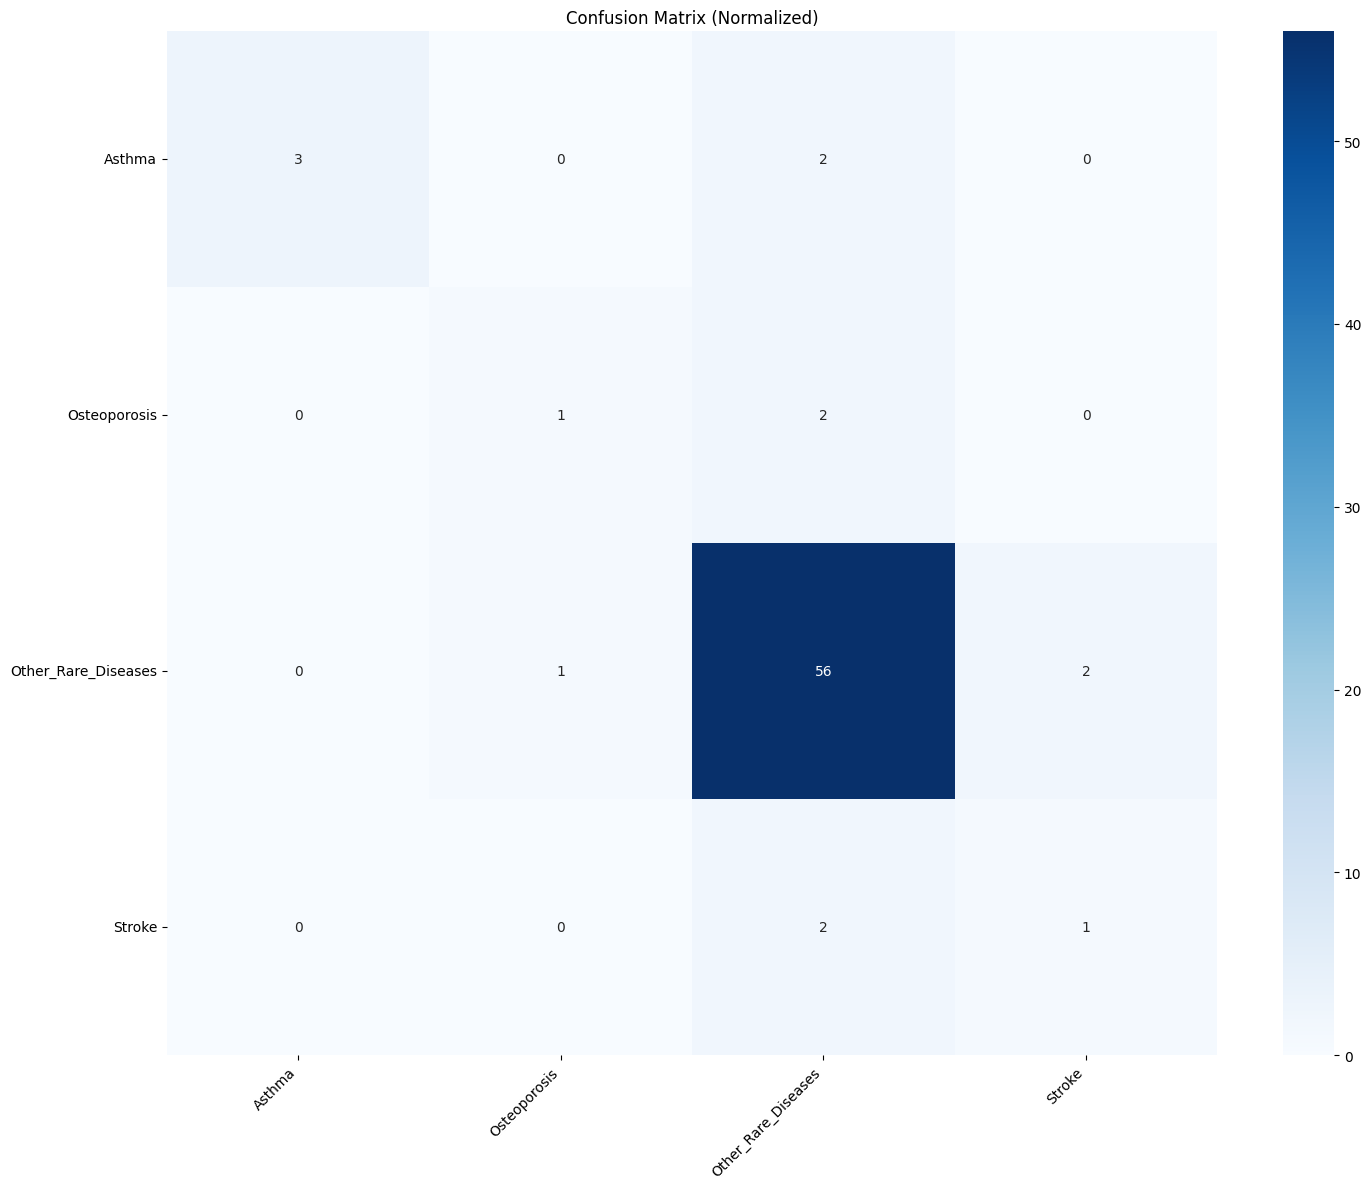

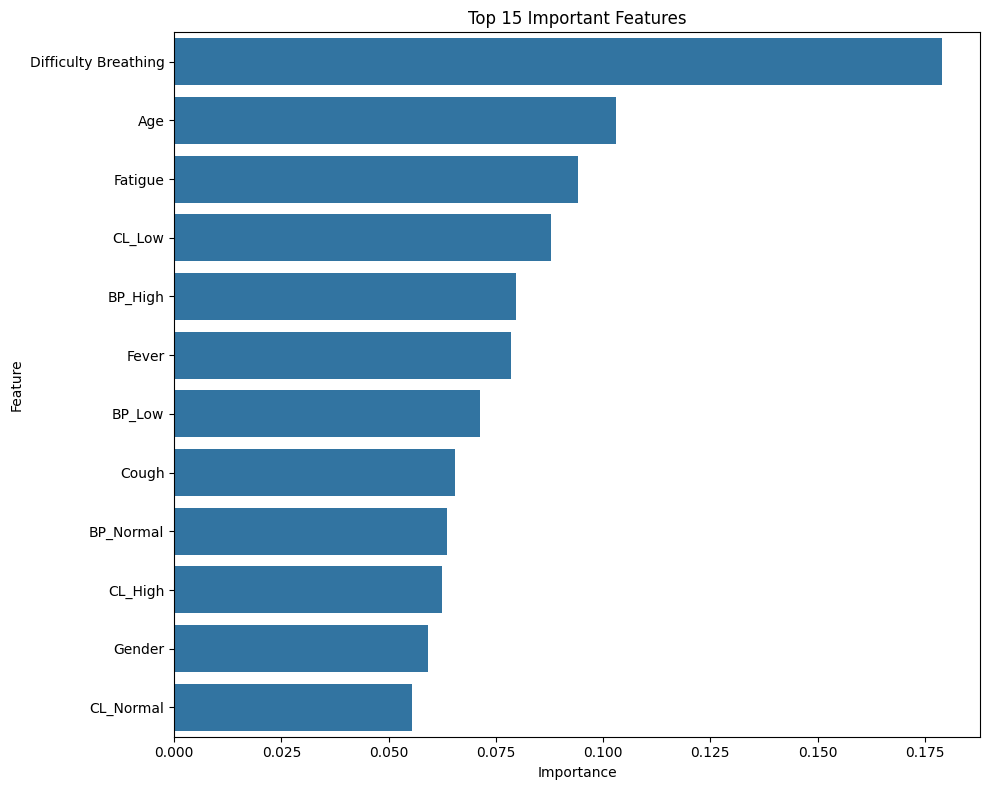

In [6]:
print("\n=== BƯỚC 5: ĐÁNH GIÁ MÔ HÌNH ===")

# Encode y_test using the same LabelEncoder used for y_res
y_test_encoded = label_encoder.transform(y_test)

y_pred = best_model.predict(X_test)

# Decode y_pred back to original string labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Độ chính xác tổng thể
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_decoded):.2f}")

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_test, y_pred_decoded))

# Ma trận nhầm lẫn
plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred_decoded, labels=label_encoder.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.show()

# Feature importance
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(15))
plt.title('Top 15 Important Features')
plt.tight_layout()
plt.show()

<center># ==================== 6. LƯU MÔ HÌNH ====================
</center>

In [7]:
print("\n=== BƯỚC 6: LƯU MÔ HÌNH ===")

import os
os.makedirs('saved_model', exist_ok=True)

# Lưu các thành phần cần thiết
joblib.dump(best_model, 'saved_model/best_model.pkl')
joblib.dump(label_encoders, 'saved_model/label_encoders.pkl')
joblib.dump(X.columns.tolist(), 'saved_model/feature_names.pkl')
joblib.dump(disease_names_v, 'saved_model/disease_encoder.pkl')  # Thêm dòng này

print("Đã lưu mô hình và các thành phần thành công!")


=== BƯỚC 6: LƯU MÔ HÌNH ===
Đã lưu mô hình và các thành phần thành công!
